# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [108]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = 'data/train.p'
validation_file= 'data/valid.p'
testing_file = 'data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

assert len(X_train) == len(y_train)
assert len(X_valid) == len(y_valid)
assert len(X_test) == len(y_test)
print('Training set size: ', len(X_train))
print('Validation set size: ', len(X_valid))
print('Test set size: ', len(X_test))

Training set size:  34799
Validation set size:  4410
Test set size:  12630


---

## Step 1: Dataset Summary & Exploration


### Basic Summary of the Data Set

In [109]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results
import csv

# TODO: Number of training examples
n_train = len(X_train)

# TODO: Number of testing examples.
n_test = len(X_test)

# TODO: What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# TODO: How many unique classes/labels there are in the dataset.
csv_file='./signnames.csv'
sign_dict={}
n_classes = 0
with open(csv_file) as f:
    reader = csv.reader(f)
    for row in reader:
        if row[0] != 'ClassId':
            sign_dict[int(row[0])]=row[1]
n_classes=len(sign_dict)


print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Exploratory visualization of the dataset

image index:  26432


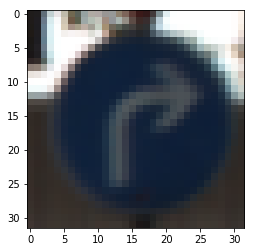

Turn right ahead


In [110]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.
import random
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

def show_random_image(image_set, lbl_set):
    r_ind = random.randint(0, n_train)
    print('image index: ', r_ind)
    image=image_set[r_ind]
    if image.shape[2]==1:
        plt.imshow(image.reshape(image.shape[0], image.shape[1]))
    else:
        plt.imshow(image)
    plt.show()
    print(sign_dict[lbl_set[r_ind]])
    
show_random_image(X_train, y_train)

#### Bar graph visualization of traffic signs data
We get an idea of a count of each sign

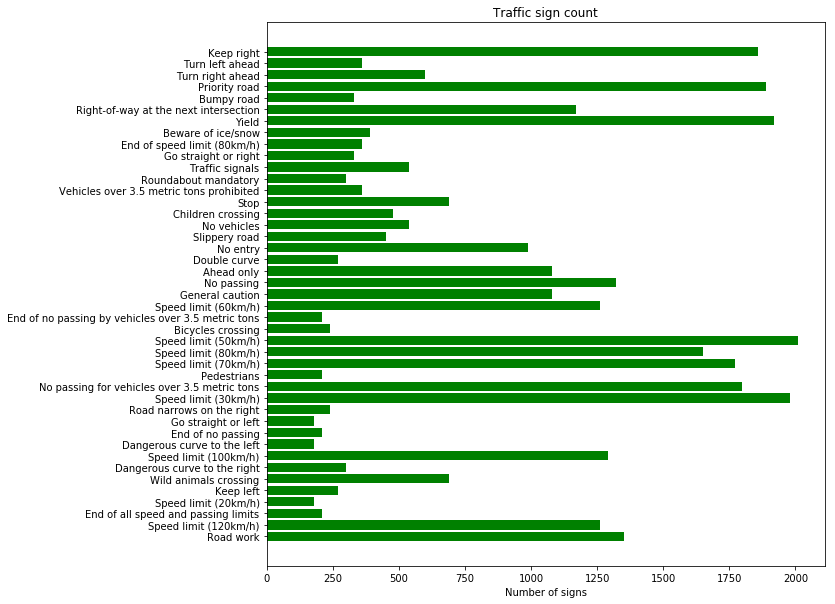

In [57]:
import numpy as np
import matplotlib.pyplot as plt
#plt.rcdefaults()

def create_signcounts(y_arr):
    sign_count_dict={}
    for key in y_arr:
        if key in sign_count_dict:
            sign_count_dict[key]+=1
        else:
            sign_count_dict[key]=1
    sign_count_name={}
    for key, val in sign_dict.items():
        sign_count_name[val]=sign_count_dict[key]
    return sign_count_name


def plt_tsign_bar(sign_count_dict):
    
    #fig, ax = plt.subplots()
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)

     

    # Traffic signs
    t_signs=[]
    t_sign_counts=[]
    for k, v in sign_count_dict.items():
        t_signs.append(k)
        t_sign_counts.append(v)

    y_pos = np.arange(len(t_signs))

    ax.barh(y_pos, t_sign_counts, align='center',color='green')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(t_signs)
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel('Number of signs')
    #ax.set_ylabel('Various sign types')
    ax.set_title('Traffic sign count')

    plt.show()

sign_count_dict=create_signcounts(y_train)
#print(sum(sign_count_dict.values()))
plt_tsign_bar(sign_count_dict)


----

## Step 2: Design and Test a Model Architecture
    

### Pre-process the Data Set (normalization)

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

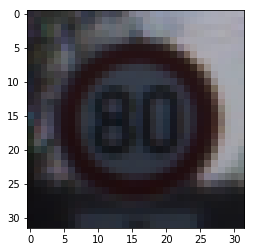

Normalized output


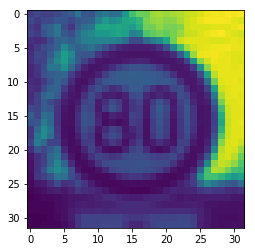

shape of normalized img:  (32, 32, 1)


In [111]:
### Preprocess the data here. Preprocessing steps could include normalization, converting to grayscale, etc.
### Feel free to use as many code cells as needed.
import cv2
import numpy as np
           

def normalize_img(img, alpha=0, beta=1):
    #first we grey scale it
    #print('initial shape:', img.shape )
    img = cv2.cvtColor( img, cv2.COLOR_RGB2GRAY )
    #print('shape after greyscale: ', img.shape)
    
    
    dst = img.copy() #needed for version compat issues    
    img = cv2.normalize(img, dst, alpha, beta, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    #print('shape after normalization', img.shape)
    
    #to retain the shape of the image
    img=np.expand_dims(img, axis=2)
    #print('shape after expanding dim', img.shape)
    return img

img1=X_train[12949]
plt.imshow(img1)
plt.show()

print('Normalized output')
img2=normalize_img(img1)
plt.imshow(img2.reshape(32, 32))
plt.show()
print('shape of normalized img: ', img2.shape)

image index:  18512


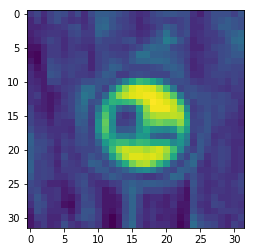

No passing for vehicles over 3.5 metric tons


In [112]:
#Normalize all the images since we tested it works
def normalize_img_arr(img_arr):
    X_copy=[]
    for i in range(len(img_arr)):
        norm_img=normalize_img(img_arr[i])
        X_copy.append(norm_img)
    return X_copy

X_train=normalize_img_arr(X_train)
X_valid=normalize_img_arr(X_valid)
X_test=normalize_img_arr(X_test)
show_random_image(X_train, y_train)

### Model Architecture

In [114]:
### We use the Lenet architecture as the starting point
import tensorflow as tf
from tensorflow.contrib.layers import flatten

EPOCHS=50
BATCH_SIZE = 128

def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # SOLUTION: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # SOLUTION: Activation.
    conv1 = tf.nn.relu(conv1)

    # We remove the pooling layer from LeNet
    # SOLUTION: Pooling. Input = 28x28x6. Output = 14x14x6.
    #conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Layer 2: Convolutional. Output = 10x10x16.
    # when no max pool above so output size changes to 24x24x16
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # SOLUTION: Activation.
    conv2 = tf.nn.relu(conv2)

    # We remove the pooling layer from LeNet
    # SOLUTION: Pooling. Input = 10x10x16. Output = 5x5x16.
    #conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Flatten. Input = 5x5x16. Output = 400.
    #no max pool Output = 9216
    fc0   = flatten(conv2)
    
    # SOLUTION: Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(9216, 1200), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(1200))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # SOLUTION: Activation.
    fc1    = tf.nn.relu(fc1)

    # SOLUTION: Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(1200, 300), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(300))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # SOLUTION: Activation.
    fc2    = tf.nn.relu(fc2)

    # SOLUTION: Layer 5: Fully Connected. Input = 84. Output = 43
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(300, n_classes), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(n_classes))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

##test compile
#x = tf.placeholder(tf.float32, (None, 32, 32, 1))
#logits = LeNet(x)

#with tf.Session() as sess:
#    sess.run(tf.global_variables_initializer())
#    l=sess.run(logits, feed_dict={x:X_train[0:2]})
#    print(l)

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [115]:
#the input features and labels
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)

#### Training pipeline

In [116]:
rate = 0.001

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

#### Model evaluation

In [117]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

#### Train the model

In [11]:
from sklearn.utils import shuffle


with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './traffic_sign_classifier_lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.878

EPOCH 2 ...
Validation Accuracy = 0.885

EPOCH 3 ...
Validation Accuracy = 0.916

EPOCH 4 ...
Validation Accuracy = 0.911

EPOCH 5 ...
Validation Accuracy = 0.929

EPOCH 6 ...
Validation Accuracy = 0.916

EPOCH 7 ...
Validation Accuracy = 0.922

EPOCH 8 ...
Validation Accuracy = 0.924

EPOCH 9 ...
Validation Accuracy = 0.946

EPOCH 10 ...
Validation Accuracy = 0.939

EPOCH 11 ...
Validation Accuracy = 0.903

EPOCH 12 ...
Validation Accuracy = 0.922

EPOCH 13 ...
Validation Accuracy = 0.924

EPOCH 14 ...
Validation Accuracy = 0.940

EPOCH 15 ...
Validation Accuracy = 0.941

EPOCH 16 ...
Validation Accuracy = 0.934

EPOCH 17 ...
Validation Accuracy = 0.932

EPOCH 18 ...
Validation Accuracy = 0.946

EPOCH 19 ...
Validation Accuracy = 0.928

EPOCH 20 ...
Validation Accuracy = 0.937

EPOCH 21 ...
Validation Accuracy = 0.942

EPOCH 22 ...
Validation Accuracy = 0.953

EPOCH 23 ...
Validation Accuracy = 0.956

EPOCH 24 ...
Validation Accura

#### Test the model
NOTE: Only once after validation is greater than .93 or higer

In [11]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.944


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

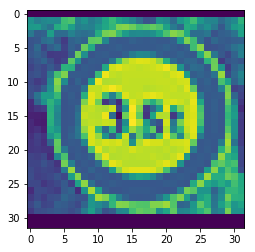

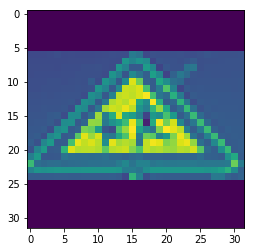

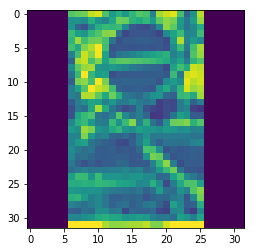

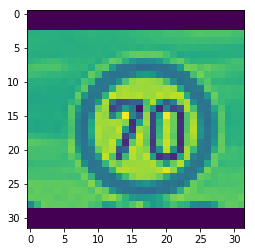

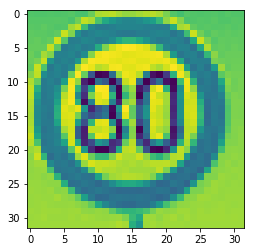

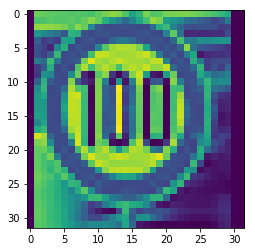

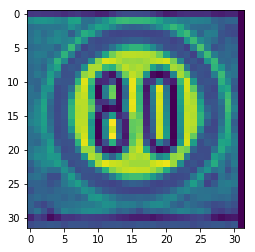

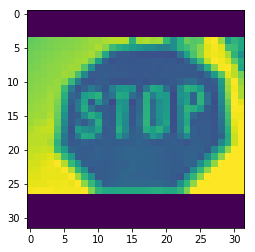

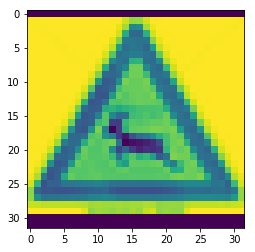

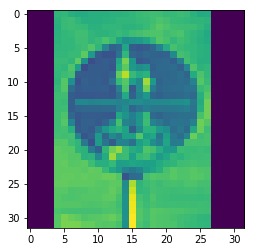

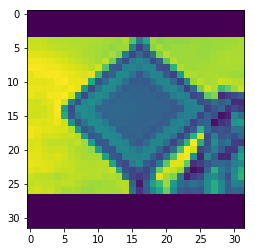

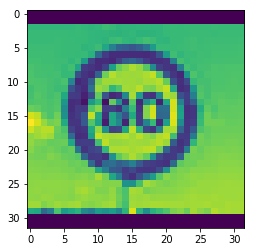

In [119]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
import os,sys
from PIL import Image

def read_resize_img(img_file_path, sz=32):
    jpg = Image.open(img_file_path)    
    jp_sz=jpg.size
    max_sz = max(jp_sz[0], jp_sz[1])
    scaling=sz/max_sz
    r_jpg = jpg.resize(( int(scaling*jp_sz[0]), int(scaling*jp_sz[1]) ) , Image.ANTIALIAS)
    npx = np.array(r_jpg)
    return npx

def pad_img(img, sz=32):
    y=img.shape[0]
    x=img.shape[1]
    yd=sz-y
    y1=int(yd/2)
    y2=yd-y1
    xd=sz-x
    x1=int(xd/2)
    x2=xd-x1
    pad_img = np.pad(img, ((y1, y2), (x1, x2), (0, 0)), 'constant')
    return pad_img
    
def plot_img(imgp):
    if imgp.shape[2]==1:
        plt.imshow(imgp.reshape(imgp.shape[0], imgp.shape[1]))
    else:
        plt.imshow(imgp)
    plt.show()
    
def read_img_from_file(img_file):
    np_img = pad_img(read_resize_img("images_from_web/" + img_file))   
    np_img = normalize_img(np_img)
    return np_img

def read_all_images(img_files, plot=False):
    new_img_arr=[]
    for img_file in img_files:
        np_img = read_img_from_file(img_file)
        if plot:
            plot_img(np_img)
        new_img_arr.append(np_img)
    return new_img_arr
    
#images got from the web
new_images=['3_5_ton.jpg', 'children.jpg', 'no_entry.jpg', 'sl_70.jpg', 'sl_80.jpg', 'sl_100.jpg', 'sl_80_2.jpg',
            'stop.jpg', 'wild_animals.jpg', 'pedestrians.jpg', 'priority.jpg', 'sl_80_4.jpg']

#their y values 
y_new_images=[10, 28, 17, 4, 5, 7, 5, 
             14, 31, 27, 12, 5]

rd_imgs=read_all_images(new_images, True)


##### get index with max probability 
Could have used tf.nn.top_k(), but that is used later on...

In [120]:
def get_max_index(lits):
    maxi=-1
    maxv=0.
    for i, j in enumerate(lits):
        if maxi == -1:
            maxi=i
            maxv=j
        elif j>maxv:
            maxi=i
            maxv=j
    return maxi
    

### Predict the Sign Type for Each Image

In [121]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.


rd_imgs_2=read_all_images(new_images)
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    l=sess.run(logits, feed_dict={x:rd_imgs_2})
    #print(l)
    for i, j in enumerate(l):
        plot_img(read_img_from_file(new_images[i]))
        s_idx = get_max_index(j)
        print("prediction:", sign_dict[s_idx])



NotFoundError: Key Variable_10 not found in checkpoint
	 [[Node: save_1/RestoreV2_6 = RestoreV2[dtypes=[DT_FLOAT], _device="/job:localhost/replica:0/task:0/cpu:0"](_recv_save_1/Const_0, save_1/RestoreV2_6/tensor_names, save_1/RestoreV2_6/shape_and_slices)]]

Caused by op 'save_1/RestoreV2_6', defined at:
  File "/home/khush/anaconda3/envs/carnd-term1/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/khush/anaconda3/envs/carnd-term1/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/khush/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/khush/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/khush/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/home/khush/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/khush/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/home/khush/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/khush/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/khush/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/khush/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/khush/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/khush/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/khush/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/khush/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/home/khush/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/khush/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/khush/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/khush/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/khush/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-117-03f1bf2fec56>", line 3, in <module>
    saver = tf.train.Saver()
  File "/home/khush/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 1000, in __init__
    self.build()
  File "/home/khush/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 1030, in build
    restore_sequentially=self._restore_sequentially)
  File "/home/khush/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 624, in build
    restore_sequentially, reshape)
  File "/home/khush/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 361, in _AddRestoreOps
    tensors = self.restore_op(filename_tensor, saveable, preferred_shard)
  File "/home/khush/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 200, in restore_op
    [spec.tensor.dtype])[0])
  File "/home/khush/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/tensorflow/python/ops/gen_io_ops.py", line 441, in restore_v2
    dtypes=dtypes, name=name)
  File "/home/khush/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 759, in apply_op
    op_def=op_def)
  File "/home/khush/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2240, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/khush/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1128, in __init__
    self._traceback = _extract_stack()

NotFoundError (see above for traceback): Key Variable_10 not found in checkpoint
	 [[Node: save_1/RestoreV2_6 = RestoreV2[dtypes=[DT_FLOAT], _device="/job:localhost/replica:0/task:0/cpu:0"](_recv_save_1/Const_0, save_1/RestoreV2_6/tensor_names, save_1/RestoreV2_6/shape_and_slices)]]


### Analyze Performance

In [37]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(rd_imgs_2, y_new_images)
    print("Test Accuracy for new images = {:.3f}".format(test_accuracy))

Test Accuracy for new images = 0.417


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

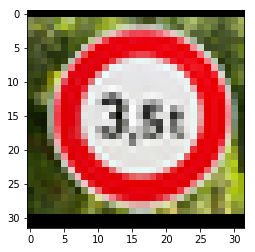

0.52851 No passing
0.463034 Speed limit (100km/h)
0.00448913 Vehicles over 3.5 metric tons prohibited
0.00354507 No passing for vehicles over 3.5 metric tons
0.00016274 Speed limit (30km/h)


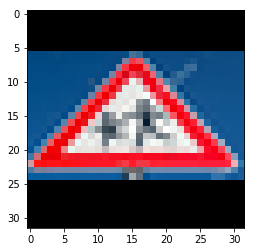

0.91767 Speed limit (80km/h)
0.0692503 Vehicles over 3.5 metric tons prohibited
0.0128318 End of speed limit (80km/h)
0.000123661 Road work
8.03728e-05 Go straight or right


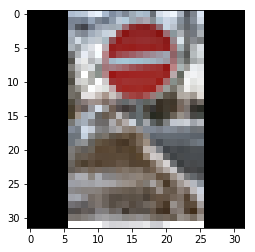

0.923496 No entry
0.0701135 Keep right
0.00621455 Children crossing
8.90776e-05 Priority road
4.26521e-05 End of all speed and passing limits


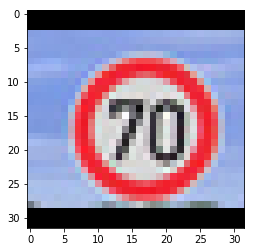

1.0 Speed limit (70km/h)
4.01033e-07 Speed limit (20km/h)
3.91127e-14 Speed limit (30km/h)
5.03986e-23 Go straight or left
4.40574e-24 Speed limit (50km/h)


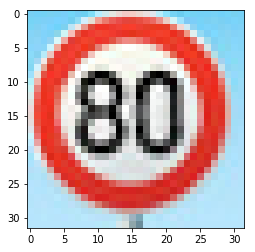

1.0 Speed limit (30km/h)
6.47477e-09 Turn right ahead
8.74309e-10 Speed limit (20km/h)
1.70736e-10 End of speed limit (80km/h)
8.31932e-11 Speed limit (50km/h)


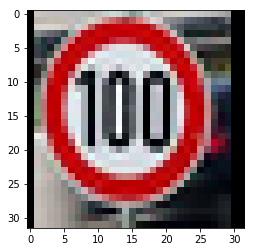

0.511809 Yield
0.485767 Speed limit (30km/h)
0.00133314 Speed limit (60km/h)
0.000595286 Speed limit (80km/h)
0.000392668 Bicycles crossing


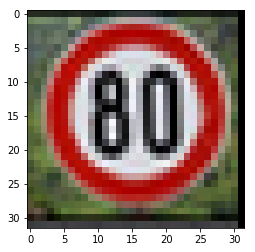

0.982456 Speed limit (30km/h)
0.0147121 Speed limit (50km/h)
0.00189145 End of speed limit (80km/h)
0.000917001 Speed limit (80km/h)
2.19487e-05 Speed limit (60km/h)


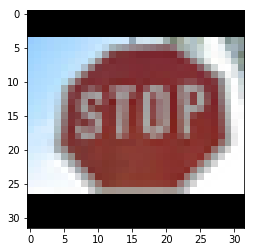

1.0 Stop
2.53289e-10 Speed limit (30km/h)
3.00835e-12 Speed limit (60km/h)
2.66195e-12 Speed limit (50km/h)
4.50532e-13 Speed limit (80km/h)


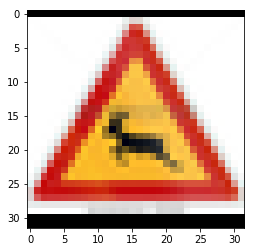

0.528538 Wild animals crossing
0.402106 Slippery road
0.0624284 Dangerous curve to the left
0.00545433 Double curve
0.00126844 Road work


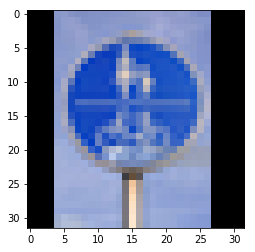

0.510296 Ahead only
0.476581 Turn left ahead
0.0130876 Keep right
2.71537e-05 Turn right ahead
2.98298e-06 Roundabout mandatory


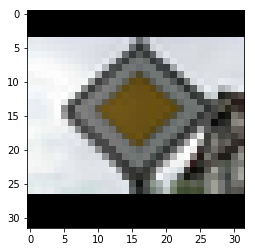

1.0 Priority road
9.51779e-11 Roundabout mandatory
4.03637e-12 Speed limit (30km/h)
1.85692e-13 End of speed limit (80km/h)
1.76652e-13 Keep right


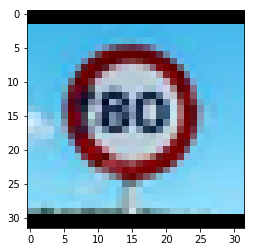

0.493079 No passing for vehicles over 3.5 metric tons
0.344341 Speed limit (80km/h)
0.160355 Speed limit (60km/h)
0.00172338 Speed limit (50km/h)
0.00041306 Speed limit (100km/h)


In [38]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    l=sess.run(logits, feed_dict={x:rd_imgs_2})
    softmax=sess.run(tf.nn.softmax(tf.constant(l)))
    #print(softmax)
    top_5 = sess.run(tf.nn.top_k(tf.constant(softmax), k=5))
    #print("top 5 probs:", top_5)
    for i, idx in enumerate(top_5.indices):
        plot_img(read_img_from_file(new_images[i]))
        v = top_5.values[i]
        for j in range(5):
            print(v[j], sign_dict[idx[j]])


### Accuracy of prediction of 80 km/h speed limit on the test set
We do this, because the trained model performed poorly on all new images of '80 km/h', confusing it with '30 km/h' most of the time


3 5


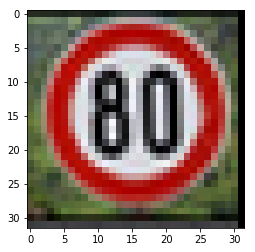

Test Accuracy of sign Speed limit (80km/h)(3) = 0.000


In [39]:
def extract_images_of_type(sign_id, x_arr, y_arr):
    filtered_x=[]
    filtered_y=[]
    for i, v in enumerate(y_arr):
        if v==sign_id:
            filtered_x.append(x_arr[i])
            filtered_y.append(y_arr[i])
    return filtered_x, filtered_y

#agg_acc=0.
#sumn=0.
filter_id=5
sign_name = sign_dict[filter_id]
#print('filtering sign: ', sign_name)
x_filter, y_filter=extract_images_of_type(filter_id, rd_imgs, y_new_images)
n = len(x_filter)
print(n, y_filter[1])

plot_img(x_filter[1])

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(x_filter, y_filter)
    #agg_acc+=n*test_accuracy
    #sumn+=n
    print("Test Accuracy of sign "+ sign_name + "(" + str(n) + ") = {:.3f}".format(test_accuracy))
    
#agg_acc/=sumn
#print('Overall accuracy: ', agg_acc)
    

---

## Step 4: Visualize the Neural Network's State with Test Images

 

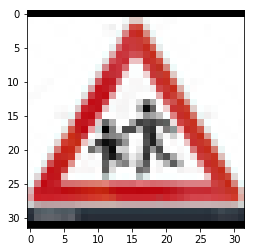

Children crossing


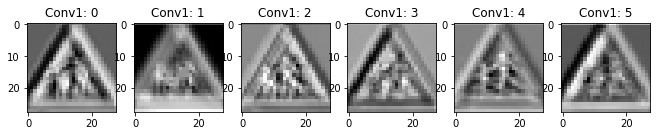

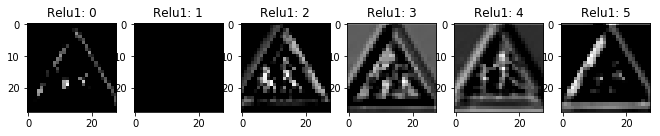

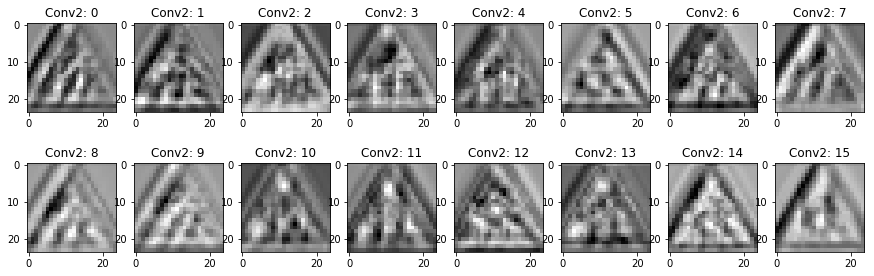

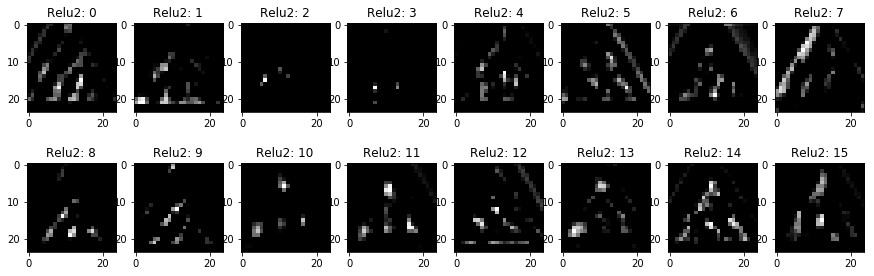

In [17]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1, label=""):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it maybe having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    pref='FeatureMap'
    if len(label)>0:
        pref = label + ": "
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column        
        plt.title(pref + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")
            

#visulaize children crossing
img_ind=1
# speed limit 80
#img_ind=4
   
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    plot_img(rd_imgs[img_ind])
    print(sign_dict[y_new_images[img_ind]])
    conv1 = sess.graph.get_tensor_by_name('Conv2D:0')
    outputFeatureMap(rd_imgs[img_ind:img_ind+1], conv1, label='Conv1')
    relu1 = sess.graph.get_tensor_by_name('Relu:0')
    outputFeatureMap(rd_imgs[img_ind:img_ind+1], relu1, plt_num=2, label='Relu1')
    conv2 = sess.graph.get_tensor_by_name('Conv2D_1:0')
    outputFeatureMap(rd_imgs[img_ind:img_ind+1], conv2, plt_num=3, label='Conv2')
    relu2 = sess.graph.get_tensor_by_name('Relu_1:0')
    outputFeatureMap(rd_imgs[img_ind:img_ind+1], relu2, plt_num=4, label='Relu2')
    

### Question on the feature map of layers

Discuss how you used the visual output of your trained network's feature maps to show that it had learned to look for interesting characteristics in traffic sign images


**Answer:**
Conv1 layer features have lot of similarity with the original image. But even there each cell highlights some different things. Example some have caught the right slanting edge, and others the left. 
The Relu layer makes the image more dark. Naturally so, as it catches only values above 0. (I guess matplotlib normalizes the values in an above 0 range, before plotting). So Relu layer shows only the most prominent features. 
By Conv2 layer number of feature matrices are 16. So I guess, each one looks for something specific. For some its hard to tell what they are looking. 
Again Relu2 after conv2, becomes even more sparse. Some where in the bits of that layer, we have encoded the necessary high level features. As the thing works!
